## <center> Q-Learning - Discrete Actions</center>


In [1]:
from IPython.display import clear_output
import time
import gym
import numpy as np
import matplotlib.pyplot as plt

### PART 1: 

Setting up Frozen Lake Environment

The agent controls the movement of a character in a grid world. Some tiles of the grid are walkable, and others lead to the agent falling into the water. Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction. The agent is rewarded for finding a walkable path to a goal tile.

The surface is described using a grid like the following:

    S | F | F | F
    - - - - - - -
    F | H | F | H
    - - - - - - -
    F | F | F | H
    - - - - - - -
    H | F | F | G  

- S: starting point, safe 
- F: frozen surface, safe)
- H: hole, fall to your doom)
- G: goal, where the frisbee is located


The episode ends when you reach the goal or fall in a hole. You receive a reward of 1 if you reach the goal, and zero otherwise. Link to Environment: https://gym.openai.com/envs/FrozenLake-v0/

We will be removing "slippery" from the environment, so there is no randomness to the direction. More info: https://github.com/openai/gym/issues/565

----
And finally, depending on your computer specs or patience, you can scale the size of the lake up or down:

https://stackoverflow.com/questions/55006689/how-to-generate-a-random-frozen-lake-map-in-openai

To keep things simply, we'll use the default 4by4 grid, but check out the link above if you're crazy enough to go to some huge N by N grid.

In [2]:
# from gym.envs.toy_text.frozen_lake import generate_random_map

# random_map = generate_random_map(size=3, p=0.5)


----

#### Environment set up

**Here we register a new environment, where is_slippery=False.**

In [3]:
from gym.envs.registration import register

try:

    register(
        id='FrozenLakeNotSlippery-v0', # make sure this is a custom name!
        entry_point='gym.envs.toy_text:FrozenLakeEnv',
        kwargs={'map_name' : '4x4', 'is_slippery': False},
        max_episode_steps=100, # if goal not completed stops after this number of episodes
        reward_threshold=.8196, # optimum = .8196 --> not useful for binary goals
    )
except:
    print('You probably ran this cell twice, accidentally trying to register a new env with the same id twice.')
    print("Either change the id, or just continue, knowing your id was already registered")

**Let's run it with some random actions.**

In [4]:
env = gym.make("FrozenLakeNotSlippery-v0")  # Load FrozenLake
env.reset()  # Reset to initial state
for _ in range(5):
    a = env.render(mode="ansi")  # Render on the screen
    print(a)
    action = env.action_space.sample()  # chose a random action
    env.step(action)  # Perform random action on the environment
    time.sleep(0.5)
env.close()  # dont forget to close the environment


SFFF
FHFH
FFFH
HFFG

  (Left)
SFFF
FHFH
FFFH
HFFG

  (Down)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG

  (Right)
SFFF
FHFH
FFFH
HFFG



#### Cleaning the output through each iteration

In [5]:
env = gym.make("FrozenLakeNotSlippery-v0")  # Load FrozenLake
env.reset()

for _ in range(5):
    clear_output(wait=True) # Clears the previous output
    a = env.render(mode="ansi") 
    print(a)
    action = env.action_space.sample()  
    env.step(action) 
    time.sleep(0.5)
env.close()  

  (Up)
SFFF
FHFH
FFFH
HFFG



#### Gameplay

In [6]:
def asdw():
    '''
    This function gets the key press for gym action choice
    '''
    k = input()
    if k == 'a':
        action = 0
    if k == 's':
        action = 1
    if k == 'd':
        action = 2
    if k == 'w':
        action = 3
        
    return action

In [7]:
env = gym.make("FrozenLakeNotSlippery-v0")  # Load FrozenLake
env.reset()  # Reset to initial state
for _ in range(10):
    env.render(mode="human")  # Render on the screen
    clear_output(wait=True)
    action = asdw()  # chose an action
    observation, reward, done, info = env.step(action)  # Perform random action on the environment
    
    if done:
        print("Game Done")
        print(f"Reward: {reward}")
        break
env.close()  # dont forget to close the environment

Game Done
Reward: 0.0


### PART 2: 

Creating the Q-Learning Table

Now that we validated the functionality of our function it is time to move on with the Q-Learning algorithm. 

Recall our Table is essentially a mapping of all possible state, action pairs and the expected reward for taking an action at a particular state that we will keep updating.


$$Q(s_t,a_t)$$

For our simple discrete Frozen Lake problem, this means we have 4 actions for columns, and 16 possible states (player location on the 4 by 4 grid). So our table will look like:

<table style="width:100%">
  <tr>
      <th></th>
    <th>A0 - LEFT</th>
    <th>A1 - DOWN</th>
    <th>A2 - RIGHT</th>
    <th>A3 - UP</th>
  </tr>
  <tr>
    <td><strong>State 0</strong></td>
    <td>Q(s,a)</td>
    <td>Q(s,a)</td>
      <td>Q(s,a)</td>
      <td>Q(s,a)</td>
  </tr>
  <tr>
      <td><strong>State 1</strong></td>
    <td>Q(s,a)</td>
    <td>Q(s,a)</td>
    <td>Q(s,a)</td>
      <td>Q(s,a)</td>
  </tr>
    <tr>
      <td><strong>State ...</strong></td>
    <td>...</td>
    <td>...</td>
    <td>...</td>
        <td>...</td>
  </tr>
    <tr>
      <td><strong>State 15</strong></td>
    <td>Q(s,a)</td>
    <td>Q(s,a)</td>
    <td>Q(s,a)</td>
        <td>Q(s,a)</td>
  </tr>
</table>

In [8]:
action_size = env.action_space.n
state_size = env.observation_space.n

#### Initial Q-Table

In [9]:
# Start with very small values for all our Q(s,a)
q_table = np.zeros([state_size, action_size])
q_table

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [10]:
q_table.shape

(16, 4)

### PART 3:

Hyperparameters

The Q-Learning update functions will require hyperparameters. we'll define them here. Often the best place to choose a good starting value is reading publications or through experimentation. Unfortunately, its very difficult to give general advice, as most environments are radically different to each other, and often hyperparameter tuning is required.


In [11]:
# It is common to leave Hyperparameters in ALL CAPS to easily locate them

EPOCHS=20000  # number of epochs/episodes to train for
ALPHA = 0.8 # aka the learning rate
GAMMA = 0.95 # aka the discount rate

**Exploration vs. Exploitation Parameters**

Basically how fast do we reduce epsilon. Reduce too fast, agent won't have enough time to learn. Reduce too slow, you're wasting time picking random actions. Key here is that these value help balance exploration (random choice) versus explotation (always picking what works for that Q(s,a). It's a tough balance!

In [12]:
# Exploration vs. Exploitation parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.001            # Exponential decay rate for exploration prob

### PART 4:
Q-Table Update Functions Methodology

Now it is time to dive into the training / Q-Table update methodology. First we will define some functions needed for training phase:

1. Action selection:

* epsilon_greedy_action_selection: Is used to implement the epsilon greedy action selection routine.
* compute_next_q_value: Computes the next Q-Values according to the formula from the lecture
* reduce_epsilon: Reduces the $\epsilon$ used for the epsilon greedy algorithm

**1. FUNCTION TO SELECT AN ACTION**

If we simply always select the argmax() Q-table value during training, we'll most likely get stuck in an explotation loop, so we'll use a random value to randomly select an action from time to time, helping the model explore, rather than exploit.

In [13]:
def action_selection(epsilon, q_table, discrete_state):
    """
    Returns an action for the agent. Note how it uses a random number to decide on exploration 
    versus explotation trade-off.
    """
    
    random_number = np.random.random()
    
    # EXPLOITATION, USE BEST Q(s,a) Value
    if random_number > epsilon:
        # Action row for a particular state
        state_row = q_table[discrete_state,:]

        # Index of highest action for state
        action = np.argmax(state_row)
    
    # EXPLORATION, USE A RANDOM ACTION
    else:
        action = env.action_space.sample()
        
    return action

**2. FUNCTION FOR Q_VALUE COMPUTATION**


$$Q(s,a) \gets (1-\alpha)*Q(s,a) + \alpha*[R(s,a) + \gamma*\max_{a}Q(s_{t+1}, a)]$$

Here we have our main Q-Learning update equation, note how it takes in the old q-value, the next optimal q value, along with our current reward, and then updates the next q value accordingly.

In [14]:
def next_q_value(old_q_value, reward, next_optimal_q_value):
    
    return (1-ALPHA)*old_q_value +  ALPHA * (reward + GAMMA * next_optimal_q_value)


**3. FUNCTION TO REDUCE EPSILON**

As training continues, we need to balance explotation versus exploration, we want ot make sure our agent doesn't get trapped in a cycle going from an square to another square back and forth. We also don't want our agent permanently choosing random values. We'll use the function below to try to balance this.

$$ \epsilon = \epsilon_{min} + (\epsilon_{max} - \epsilon_{min})*e^{-\lambda*\tau}$$

- $\lambda$: decay rate
- $\tau$: epoch

In [15]:
def reduce_epsilon(epsilon,epoch):
    
    return min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*epoch)

### PART 5:

Training of Agent and Updating Q-Table

In [16]:
# Reset just in case
q_table = np.zeros([state_size, action_size])
total_reward = 0
epsilon = 1

In [17]:
# List of rewards
rewards = []

# Play 20k games
for episode in range(EPOCHS):

    # Reset the environment
    env = gym.make("FrozenLakeNotSlippery-v0")
    # To visualize the whole traninig, change render_mode to "human" --> takes a lot of time
    state = env.reset()
    done = False
    total_rewards = 0
    
    while not done:
        action = action_selection(epsilon,q_table, state)

        # Take the action (a) and observe the outcome state(s') and reward (r)
        new_state, reward, done, info = env.step(action)

        
        # Look up current/old qtable value Q(s_t,a_t)
        old_q_value =  q_table[state,action]  

        # Get the next optimal Q-Value
        next_optimal_q_value = np.max(q_table[new_state, :])  

        # Compute next q value
        next_q = next_q_value(old_q_value, reward, next_optimal_q_value)   

        # Update Q Table
        q_table[state,action] = next_q

        
        
        total_rewards = total_rewards + reward
        
        # Our new state is state
        state = new_state

        
    episode += 1
    # Reduce epsilon (because we need less and less exploration)
    epsilon = reduce_epsilon(epsilon,episode) 
    rewards.append(total_rewards)


env.close()

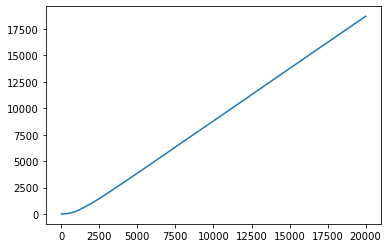

In [18]:
plt.plot(range(EPOCHS),np.cumsum(rewards))

In [19]:
q_table

array([[0.73509189, 0.77378094, 0.77378094, 0.73509189],
       [0.73509189, 0.        , 0.81450625, 0.77378094],
       [0.77378094, 0.857375  , 0.77378094, 0.81450625],
       [0.81450625, 0.        , 0.77378094, 0.77378094],
       [0.77378094, 0.81450625, 0.        , 0.73509189],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.        , 0.81450625],
       [0.        , 0.        , 0.        , 0.        ],
       [0.81450625, 0.        , 0.857375  , 0.77378094],
       [0.81450625, 0.9025    , 0.9025    , 0.        ],
       [0.857375  , 0.95      , 0.        , 0.857375  ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.95      , 0.857375  ],
       [0.9025    , 0.95      , 1.        , 0.9025    ],
       [0.        , 0.        , 0.        , 0.        ]])

### PART 5:
Using Learned Q Table Results

Now it is time for a final evaluation round!
Let's see how well our first RL agent performs

In [20]:
env = gym.make("FrozenLakeNotSlippery-v0")
state = env.reset()

for _ in range(100):
    a = env.render(mode="ansi") 
    print(a)
    
    action = np.argmax(q_table[state])  # and chose action from the Q-Table
    state, reward, done, info = env.step(action) # Finally perform the action

    time.sleep(1)
    clear_output(wait=True)
    
    if done:
        break

env.close()

  (Right)
SFFF
FHFH
FFFH
HFFG

